<a href="https://colab.research.google.com/github/senasung37/startup_project/blob/main/%EA%B8%B0%EC%97%85%ED%98%91%EC%97%85_ML%EA%B2%AC%EC%A0%81%EA%B0%80%EB%B6%84%EC%84%9D_%EB%B3%B4%EC%95%88%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리


In [1]:
#라이브러리
import pandas as pd
import numpy as np
import math
import sklearn

import matplotlib as mpl
from matplotlib import style
import matplotlib.pyplot as plt

from numpy import linalg as LA
from numpy import array
from numpy.linalg import norm

from scipy import stats

!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score  
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

#프로파일 리포트 라이브러리 설치
#!pip uninstall pandas_profiling
#!pip install pandas-profiling[notebook]
#!pip install markupsafe==2.0.1

# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#데이터 로드 및 전처리

##데이터 불러오기

In [2]:
# 견적서 파일 df로 불러오기
df = pd.read_excel('견적서_변형.xlsx')
df = df.iloc[:, :10]
df.head(3)

,유저명,사업자 여부,클라이언트,총 금액,항목명,규격,수량,단가,분류,세부분류
0,Lee Jeong,1,김민찬,1500000.0,영문기사 작성,NaN,1,1000000,비즈니스,문서작업
1,이정훈,0,클래스랩,1125000.0,신문사 기사 발행,NaN,5,150000,비즈니스,문서작업
2,siren,1,이운형,8250000.0,김치찌개 팩,구수한맛50g*2ea,1000,2500,건강/미용,푸드


In [3]:
df = df.iloc[:, :10]
df.head(3)

,유저명,사업자 여부,클라이언트,총 금액,항목명,규격,수량,단가,분류,세부분류
0,Lee Jeong,1,김민찬,1500000.0,영문기사 작성,NaN,1,1000000,비즈니스,문서작업
1,이정훈,0,클래스랩,1125000.0,신문사 기사 발행,NaN,5,150000,비즈니스,문서작업
2,siren,1,이운형,8250000.0,김치찌개 팩,구수한맛50g*2ea,1000,2500,건강/미용,푸드


##데이터 전처리

In [4]:
#train, test 데이터셋 나누기, 전처리
train, test = train_test_split(df, test_size=0.2, random_state=2)

In [5]:
#프로파일 리포트
import pandas_profiling
from pandas_profiling import ProfileReport
train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#feature engineering
def fe(df):
  #테스트 행 삭제
  df = df[df["분류"].str.contains('테스트') == False]
  #단가X수량 열 생성
  df["견적가"] = df['수량'] * df['단가']
  df.drop(df.index[df['견적가'] == 0], inplace = True)
  #필요없는 열 삭제
  dels = ['유저명', '클라이언트', '항목명', '규격', '수량', '단가', '총 금액']
  df = df.drop(dels, axis=1)
  #물음표 삭제
  df['분류'] = df['분류'].str.replace('?','', regex=True)
  
  return df

In [7]:
#train, test 데이터셋 나누기, 전처리
train, test = train_test_split(df, test_size=0.2, random_state=2)
train = fe(train)
test = fe(test)

In [8]:
#x, y 데이터 나누기
target = '견적가'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [9]:
X_train

,사업자 여부,분류,세부분류
225,1,웹/앱 디자인,웹/앱 디자인
188,0,개발,개발
3,1,건강/미용,푸드
178,1,기기/기술,자동차/중장비
314,1,기기/기술,전자/소형설비
...,...,...,...
360,1,홈/리빙,인테리어
22,0,홈/리빙,인테리어
72,1,상업용 디자인,상업용 디자인
15,0,기기/기술,자동차/중장비


In [10]:
y_train

225      150000
188      220000
3       3000000
178    36000000
314      825000
         ...   
360      120000
22       675000
72        40000
15        80000
168      150000
Name: 견적가, Length: 264, dtype: int64

#모델 학습 및 분석(연속형 종속변수)

##머신러닝

In [11]:
#기준모델(y = average)
predict = y_train.mean()
y_pred = [predict] * len(y_train)

#기준모델 성능
print('*기준모델 성능')
print('mae :', mean_absolute_error(y_train, y_pred))
print('mse :', mean_squared_error(y_train, y_pred))
print('r2  :', r2_score(y_train, y_pred))

*기준모델 성능
mae : 1451293.0942952253
mse : 11436730809030.16
r2  : 0.0


In [12]:
#학습모델1 - RF Regressor, Onehot Encoding
pipe = make_pipeline(
  OneHotEncoder(),
  RandomForestRegressor(max_depth=10, n_estimators=10))

k = 3

pipe.fit(X_train, y_train)
scores_mae = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
scores_mse = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(pipe, X_train, y_train, cv=k, scoring='r2')

print('평균 mae:', scores_mae.mean())
print('평균 mse:', scores_mse.mean())
print('평균 r2:', scores_r2.mean())

평균 mae: -1601447.4911178665
평균 mse: -13941911757614.15
평균 r2: -1.0487024776635805


In [13]:
#학습모델2 - RF Regressor, Ordinal Encoding
pipe = make_pipeline(
  OrdinalEncoder(),
  RandomForestRegressor(max_depth=10, n_estimators=10))

k = 3

pipe.fit(X_train, y_train)
scores_mae = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
scores_mse = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(pipe, X_train, y_train, cv=k, scoring='r2')

print('평균 mae:', scores_mae.mean())
print('평균 mse:', scores_mse.mean())
print('평균 r2:', scores_r2.mean())

평균 mae: -1621340.6959740047
평균 mse: -14132242592198.29
평균 r2: -1.1261855172451425


In [14]:
#학습모델3 - RF Regressor, Target Encoding
pipe = make_pipeline(
  TargetEncoder(),
  RandomForestRegressor(max_depth=10, n_estimators=10))

k = 3

pipe.fit(X_train, y_train)
scores_mae = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
scores_mse = cross_val_score(pipe, X_train, y_train, cv=k, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(pipe, X_train, y_train, cv=k, scoring='r2')

print('평균 mae:', scores_mae.mean())
print('평균 mse:', scores_mse.mean())
print('평균 r2:', scores_r2.mean())

평균 mae: -1701228.226857845
평균 mse: -16258148256330.322
평균 r2: -0.8257395231149737


##ANOVA

In [15]:
#데이터 전처리
def fe_anova(df):
  #테스트 행 삭제
  df = df[df["분류"].str.contains('테스트') == False]
  #단가X수량 열 생성
  df["견적가"] = df['수량'] * df['단가']
  df.drop(df.index[df['견적가'] == 0], inplace = True)
  #물음표 삭제
  df['분류'] = df['분류'].str.replace('?','', regex=True)
  #아웃라이어 제거
  df = df[(np.abs(stats.zscore(df['견적가'])) < 2)]
  
  return df

In [16]:
df2 = fe_anova(df)

In [17]:
# 한글 폰트 세팅
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('font', family='NanumBarunGothic')
mpl.rc('font', family='NanumBarunGothic')
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [18]:
# 한글 폰트 세팅
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('font', family='NanumBarunGothic')
mpl.rc('font', family='NanumBarunGothic')

In [19]:
df2.drop(['사업자 여부'], axis=1).groupby('분류').mean().sort_values(by=['견적가'], ascending=False)

,총 금액,수량,단가,견적가
분류,,,,
비즈니스,1.595000e+06,7.428571,680666.666667,896666.666667
기기/기술,8.241816e+06,19.666667,757300.000000,877583.333333
웹/앱 디자인,2.711962e+06,4.974359,496025.641026,850000.000000
미디어,1.567875e+06,90.300000,444557.500000,749500.000000
건강/미용,1.574543e+06,90.304348,344273.913043,638826.086957
기타,9.148714e+05,3.285714,259728.571429,609914.285714
홈/리빙,1.959490e+06,7.000000,305207.936508,415977.777778
상업용 디자인,1.191409e+06,7.186667,223606.720000,406799.266667
개발,3.367554e+06,1.000000,259807.187500,259807.187500


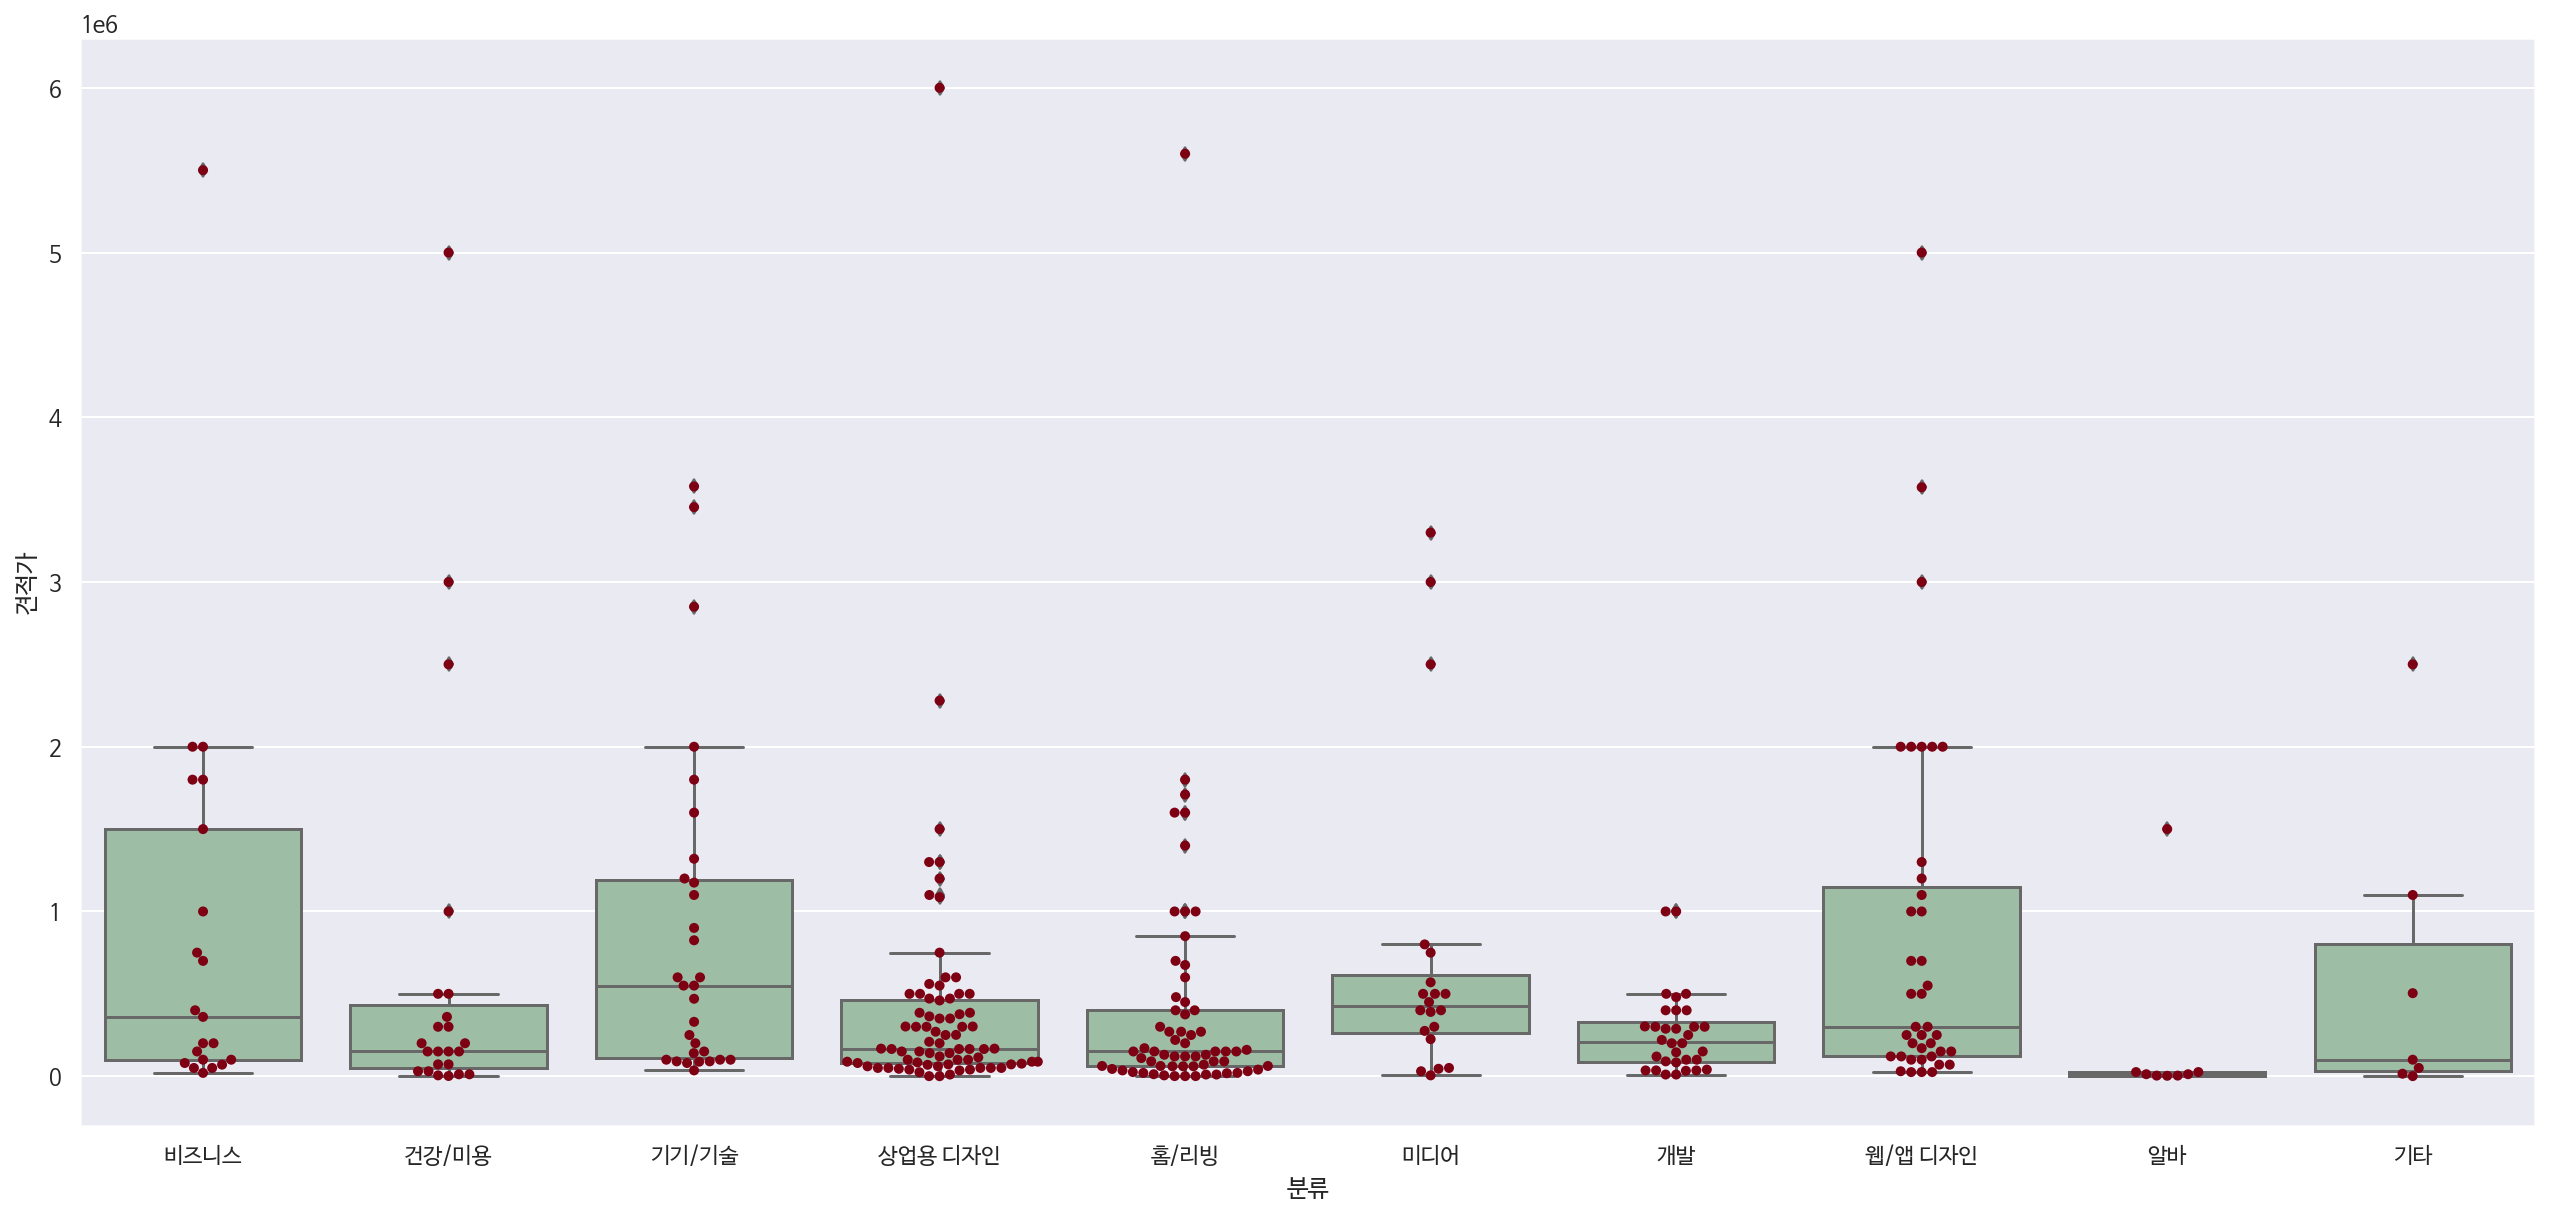

In [20]:
#분류별 시세 boxplot
import seaborn as sns
sns.set(rc={'figure.figsize':(22, 10)})
sns.set(font='NanumBarunGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
ax = sns.boxplot(x ='분류', y ='견적가', data= df2, color='#99c2a2')
ax = sns.swarmplot(x='분류', y="견적가", data=df2, color='#7d0013')
plt.show()

In [21]:
#ANOVA 분석

import scipy.stats as stats
stats.f_oneway(df2['견적가'][df2['분류'] == '비즈니스'],
               df2['견적가'][df2['분류'] == '건강/미용'],
               df2['견적가'][df2['분류'] == '기기/기술'],
               df2['견적가'][df2['분류'] == '상업용 디자인'],
               df2['견적가'][df2['분류'] == '홈/리빙'],
               df2['견적가'][df2['분류'] == '미디어'],
               df2['견적가'][df2['분류'] == '개발'],
               df2['견적가'][df2['분류'] == '웹/앱 디자인'],
               df2['견적가'][df2['분류'] == '알바'])

F_onewayResult(statistic=2.5239300639793028, pvalue=0.01137537443148226)

In [22]:
#출저: https://www.pythonfordatascience.org/anova-python/
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('견적가 ~ C(분류)', data=df2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(분류),1.656196e+13,9.0,2.243843,0.019316
Residual,2.525965e+14,308.0,NaN,NaN


In [23]:
#세부분류별 견적가
df_gr = df2.drop(['사업자 여부'], axis=1).groupby('세부분류').mean().sort_values(by=['견적가'], ascending=False)

In [24]:
df_gr

,총 금액,수량,단가,견적가
세부분류,,,,
교육,2.700000e+06,9.000000,2.000000e+05,1.800000e+06
웹/앱 개발,5.664562e+06,3.250000,7.687500e+05,1.218750e+06
자동차/중장비,1.827531e+07,1.416667,1.072875e+06,1.135375e+06
광고,1.475625e+06,1.000000,9.837500e+05,9.837500e+05
푸드,2.080375e+06,171.916667,4.223583e+05,9.244167e+05
웹/앱 디자인,2.121300e+06,4.640000,5.096000e+05,8.250000e+05
미디어,1.567875e+06,90.300000,4.445575e+05,7.495000e+05
문서작업,1.075000e+06,35.333333,3.846667e+05,7.166667e+05
전자/소형설비,1.552819e+06,31.833333,5.469167e+05,7.057222e+05


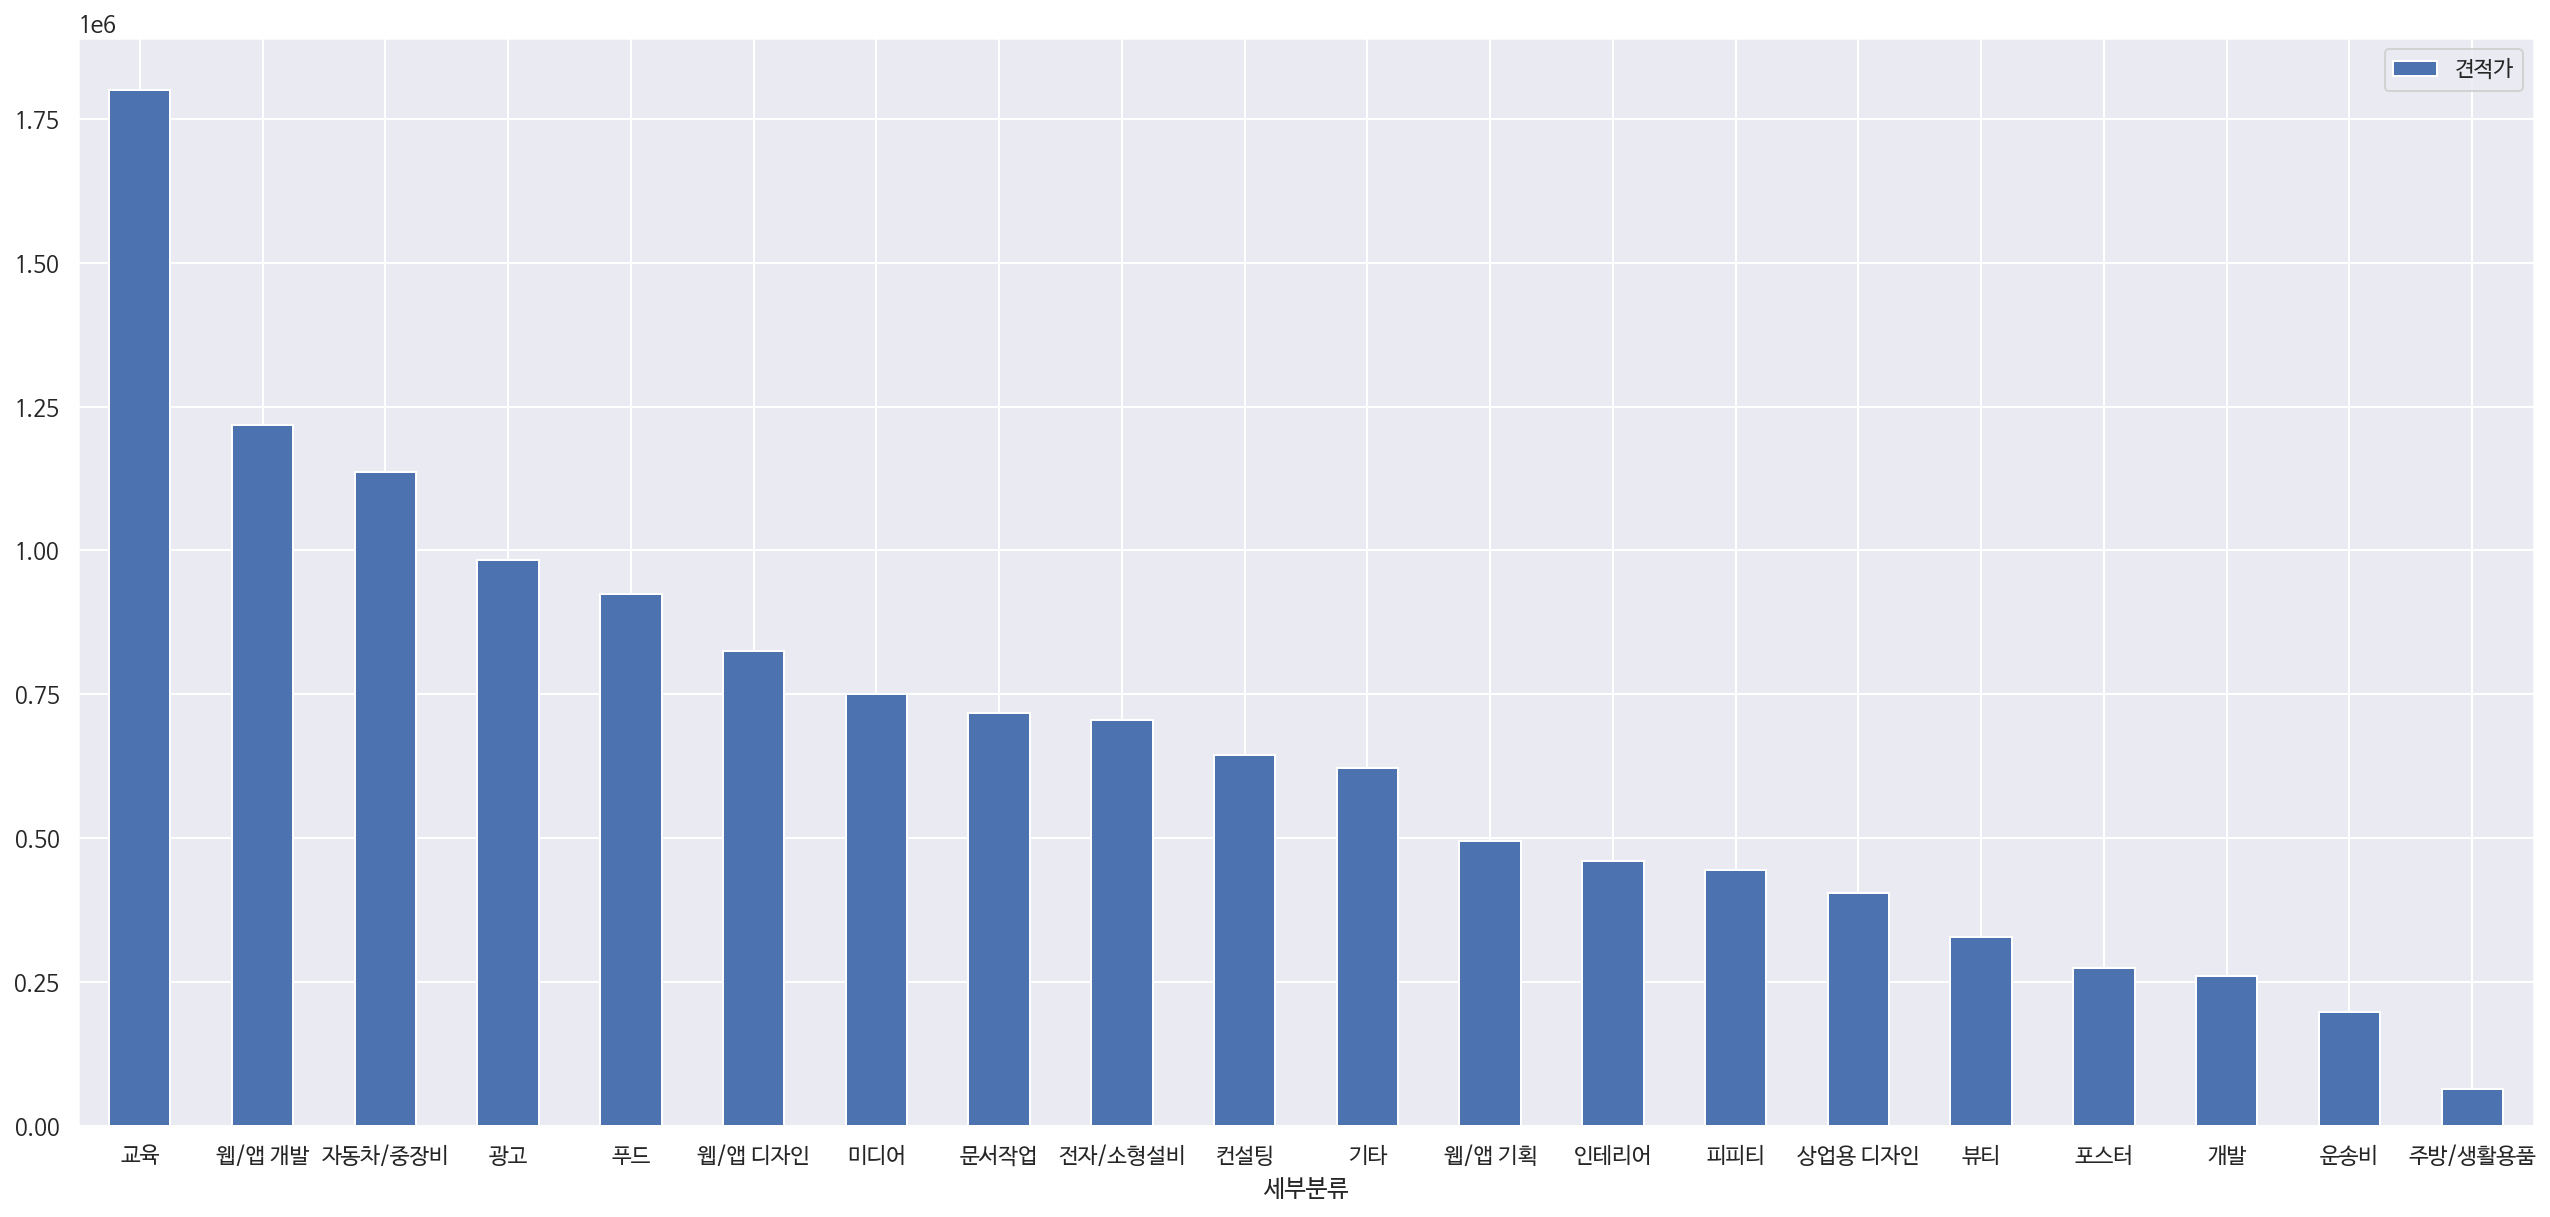

In [25]:
#세부분류별 견적가 시각화
ax = df_gr.plot.bar(y= "견적가", rot=0)

##딥러닝

In [26]:
#라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

In [27]:
df3 = df2
df3

,유저명,사업자 여부,클라이언트,총 금액,항목명,규격,수량,단가,분류,세부분류,견적가
0,Lee Jeong,1,김민찬,1500000.0,영문기사 작성,NaN,1,1000000,비즈니스,문서작업,1000000
1,이정훈,0,클래스랩,1125000.0,신문사 기사 발행,NaN,5,150000,비즈니스,문서작업,750000
2,siren,1,이운형,8250000.0,김치찌개 팩,구수한맛50g*2ea,1000,2500,건강/미용,푸드,2500000
3,James,1,자운재,8250000.0,블루베리 액기스,얼큰 50g*2ea,1000,3000,건강/미용,푸드,3000000
4,강예호,0,고객,600000.0,문서작업,매절,100,4000,비즈니스,문서작업,400000
...,...,...,...,...,...,...,...,...,...,...,...
396,허준오,1,미디어세상,9000000.0,양천구청 캐릭터 제작,타이틀(3D),1,6000000,상업용 디자인,상업용 디자인,6000000
397,허준오,1,미디어세상,4200000.0,미디어 예술상회,로고 제작,1,300000,상업용 디자인,상업용 디자인,300000
398,허준오,1,미디어세상,4200000.0,미디어 예술상회,타이틀/15초,1,2500000,미디어,미디어,2500000
399,허준오,0,오유정,4500000.0,MBC 방송 타이틀,FHD15초,1,3000000,미디어,미디어,3000000


In [28]:
#라벨 인코딩
le = preprocessing.LabelEncoder()
le.fit(df3["분류"])
df3["분류"] = le.transform(df3["분류"])

In [29]:
#x, y 지정
x = df3[["분류", "사업자 여부"]]
y = df3["견적가"]

In [30]:
#모델 지정
model = keras.Sequential([
    layers.Dense(4, input_shape=[2]),
    layers.Dense(8),
    layers.Dense(1)])

In [31]:
#optimizer
opt = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss = 'mse',
                optimizer = opt,
                metrics = ['mae', 'mse'])

In [32]:
model.fit(x, y, epochs = 100)

Epoch 1/100
10/10 [==============================] - 1s 4ms/step - loss: 1162810097664.0000 - mae: 562494.3125 - mse: 1162810097664.0000
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 1162809311232.0000 - mae: 562493.6875 - mse: 1162809311232.0000
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 1162808655872.0000 - mae: 562493.1250 - mse: 1162808655872.0000
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 1162808000512.0000 - mae: 562492.5625 - mse: 1162808000512.0000
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 1162807476224.0000 - mae: 562491.8750 - mse: 1162807476224.0000
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 1162806820864.0000 - mae: 562491.3750 - mse: 1162806820864.0000
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: 1162806034432.0000 - mae: 562490.7500 - mse: 1162806034432.0000
Epoch 8/100
10/10 [======================

#모델 분석(카테고리형 종속변수)

##종속변수 카테고리로 변경

In [34]:
# 견적서 파일 df로 불러오기
df = pd.read_excel('견적서_변형.xlsx')
df = df.iloc[:, :10]

In [35]:
#train, test 데이터셋 나누기, 전처리
train, test = train_test_split(df, test_size=0.2, random_state=2)

In [36]:
def quote(df):
  #단가X수량 열 생성
  df["견적가"] = df['수량'] * df['단가']
  df.drop(df.index[df['견적가'] == 0], inplace = True)
  return df

In [37]:
quote(train)

,유저명,사업자 여부,클라이언트,총 금액,항목명,규격,수량,단가,분류,세부분류,견적가
225,이나해,1,프리랜서앱 손승아 고객님,900000.0,앱 메인페이지 디자인 시안2개,1920x3000 pixel,1,150000,웹/앱 디자인,웹/앱 디자인,150000
188,손지영,0,유은재 대표,783000.0,3개월 서버 사용,"5,6,7월분 중 미납금액 발생 총 453,000원중 9/1 233,000원 결제 완료",1,220000,개발,개발,220000
3,James,1,자운재,8250000.0,블루베리 액기스,얼큰 50g*2ea,1000,3000,건강/미용,푸드,3000000
300,장윤진,1,나다,3000000.0,test,111,2,1000000,테스트,테스트,2000000
178,경남보트,1,이민권,66000000.0,엔진구입,머큐리 버라도 300마력,1,36000000,기기/기술,자동차/중장비,36000000
...,...,...,...,...,...,...,...,...,...,...,...
75,최송의,1,유병찬,22500.0,테스트,111,1,15000,테스트,테스트,15000
22,권오영,0,김영진,1012500.0,암막커텐 시공,2730*2450,3,225000,홈/리빙,인테리어,675000
72,최송의,1,이훈상,396000.0,B엔터 썸네일 디자인,1종 + 베리에이션 1개,2,20000,상업용 디자인,상업용 디자인,40000
15,곽철수,0,유중섭,420000.0,휀더 코팅,NaN,1,80000,기기/기술,자동차/중장비,80000


In [38]:
train.describe()

,사업자 여부,총 금액,수량,단가,견적가
count,290.000000,2.900000e+02,290.000000,2.900000e+02,2.900000e+02
mean,0.613793,3.030875e+06,19.372414,8.540687e+05,1.071092e+06
std,0.487721,7.162422e+06,110.731037,3.201268e+06,3.245552e+06
min,0.000000,1.500000e+00,1.000000,1.000000e+00,1.000000e+00
25%,0.000000,3.099750e+05,1.000000,4.000000e+04,7.200000e+04
50%,1.000000,9.000000e+05,1.000000,1.200000e+05,2.000000e+05
75%,1.000000,2.400000e+06,2.000000,3.018775e+05,5.925000e+05
max,1.000000,6.600000e+07,1000.000000,3.600000e+07,3.600000e+07


In [39]:
#견적가 percentile 구하기
d = train['견적가']
p_20 = np.percentile(d, 20)
p_40 = np.percentile(d, 40)
p_60 = np.percentile(d, 60)
p_80 = np.percentile(d, 80)


In [40]:
#feature engineering
def fe_cat(df):
  #테스트 행 삭제
  df = df[df['분류'] != '테스트']

  #단가X수량 열 생성
  df["견적가"] = df['수량'] * df['단가']
  #아웃라이어 제거
  df = df[(np.abs(stats.zscore(df['견적가'])) < 3)]

  #종속변수 카테고리화(4분위로 나눔)
  df['견적가'] = df['견적가'].apply(lambda x: 3 if x >= 5.675000e+05
                                  else 2 if x >= 2.225000e+05
                                  else 1 if x >= 8.090000e+04
                                  else 0)

  #필요없는 열 삭제
  dels = ['수량', '단가', '총 금액', '분류', '항목명', '규격']
  df = df.drop(dels, axis=1)

  return df

In [41]:
#train, test 데이터셋 나누기, 전처리
train, test = train_test_split(df, test_size=0.2, random_state=42)
train = fe_cat(train)
test = fe_cat(test)

In [42]:
#x, y 데이터 나누기
target = '견적가'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [43]:
X_train

,유저명,사업자 여부,클라이언트,세부분류
18,구은재,1,율봉로 단독,인테리어
351,차선곤,1,(재)대한인테리어산업연구원,인테리어
275,이지선,1,이지선,개발
63,김지윤,0,김유나,웹/앱 디자인
249,이승호,1,유케이블,개발
...,...,...,...,...
188,손지영,0,유은재 대표,개발
71,최송의,1,이훈상,상업용 디자인
106,강지연,1,평창옥수수,상업용 디자인
348,차선곤,1,(재)대한인테리어산업연구원,인테리어


##머신러닝

###Random forest

In [44]:
#기준모델(y = 0)
major = y_train.mode()[0]
y_base = [major] * len(y_train)
print("Value counts: \n", y_train.value_counts(normalize=True))
print("basseline accuracy: ", accuracy_score(y_train, y_base))

Value counts: 
 0    0.270270
2    0.250965
3    0.247104
1    0.231660
Name: 견적가, dtype: float64
basseline accuracy:  0.2702702702702703


In [45]:
y_base = [major] * len(y_test)
print("basseline accuracy: ", accuracy_score(y_test, y_base))

basseline accuracy:  0.265625


In [46]:
#학습모델1 - Onehot Encoding, rf
from category_encoders import OneHotEncoder
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

k = 3
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='accuracy')

In [47]:
print(f'검증정확도({k} folds):', scores)
print('onehot 평균 검증정확도:', scores.mean())

검증정확도(3 folds): [0.42528736 0.5        0.47674419]
onehot 평균 검증정확도: 0.4673438474561169


In [48]:
#학습모델1 - Ordinal Encoding, rf
pipe_ord = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

k = 3
scores_ord = cross_val_score(pipe_ord, X_train, y_train, cv=k, 
                         scoring='accuracy')

In [49]:
print(f'검증정확도({k} folds):', scores_ord)
print('ordinal 평균 검증정확도:', scores_ord.mean())


검증정확도(3 folds): [0.42528736 0.40697674 0.44186047]
ordinal 평균 검증정확도: 0.4247081885413882


In [50]:
pipe_tar = make_pipeline(
    # TargetEncoder: 범주형 변수 인코더로, 타겟값을 특성의 범주별로 평균내어 그 값으로 인코딩
    TargetEncoder(min_samples_leaf=1, smoothing=10), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

k = 3
scores_tar = cross_val_score(pipe_tar, X_train, y_train, cv=k, 
                         scoring='accuracy')

In [51]:
print(f'검증정확도({k} folds):', scores_tar)
print('target 평균 검증정확도:', scores_tar.mean())

검증정확도(3 folds): [0.42528736 0.45348837 0.5       ]
target 평균 검증정확도: 0.45959190947162076


In [52]:
print('onehot 평균 검증정확도:', scores.mean())
print('ordinal 평균 검증정확도:', scores_ord.mean())
print('target 평균 검증정확도:', scores_tar.mean())

onehot 평균 검증정확도: 0.4673438474561169
ordinal 평균 검증정확도: 0.4247081885413882
target 평균 검증정확도: 0.45959190947162076


사업자 여부, 세부분류
- onehot 평균 검증정확도: 0.4012296177492649
- ordinal 평균 검증정확도: 0.3896017107725207
- target 평균 검증정확도: 0.405105586741513

유저명, 클라이언트 추가
- onehot 평균 검증정확도: 0.4903323532032433
- ordinal 평균 검증정확도: 0.42457453443820725
- target 평균 검증정확도: 0.47487302860197805

###Randomized CV

In [53]:
#Randomized CV
from sklearn.model_selection import RandomizedSearchCV
#학습모델1 사용 - Onehot Encoding, rf
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    RandomForestClassifier(random_state=2, oob_score=True)
)

# 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
dists = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 200], 
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10],
    'randomforestclassifier__min_samples_split': [1, 3, 5, 10],
    'randomforestclassifier__max_depth': [10, 30, 50, 100, 200, 500, None], 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [54]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('정확도: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': None}
정확도:  0.4980392156862745


In [55]:
#테스트 데이터셋에 테스트
pipe =  clf.best_estimator_
print('검증세트 정확도', pipe.score(X_test, y_test))

검증세트 정확도 0.53125


사업자분류, 세부분류, onehot
- 정확도:  0.3935897435897436

유저명, 클라이언트 추가
- 정확도: 0.4903323532032433

###XGB

In [56]:
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

In [58]:
# 견적서 파일 df로 불러오기
df = pd.read_excel('견적서_변형.xlsx')
df = df.iloc[:, :10]
df

,유저명,사업자 여부,클라이언트,총 금액,항목명,규격,수량,단가,분류,세부분류
0,Lee Jeong,1,김민찬,1500000.0,영문기사 작성,NaN,1,1000000,비즈니스,문서작업
1,이정훈,0,클래스랩,1125000.0,신문사 기사 발행,NaN,5,150000,비즈니스,문서작업
2,siren,1,이운형,8250000.0,김치찌개 팩,구수한맛50g*2ea,1000,2500,건강/미용,푸드
3,James,1,자운재,8250000.0,블루베리 액기스,얼큰 50g*2ea,1000,3000,건강/미용,푸드
4,강예호,0,고객,600000.0,문서작업,매절,100,4000,비즈니스,문서작업
...,...,...,...,...,...,...,...,...,...,...
396,허준오,1,미디어세상,9000000.0,양천구청 캐릭터 제작,타이틀(3D),1,6000000,상업용 디자인,상업용 디자인
397,허준오,1,미디어세상,4200000.0,미디어 예술상회,로고 제작,1,300000,상업용 디자인,상업용 디자인
398,허준오,1,미디어세상,4200000.0,미디어 예술상회,타이틀/15초,1,2500000,미디어,미디어
399,허준오,0,오유정,4500000.0,MBC 방송 타이틀,FHD15초,1,3000000,미디어,미디어


In [59]:
#feature engineering
def fe_xgb(df):
  #테스트 행 삭제
  df = df[df["분류"].str.contains('테스트') == False]

  #단가X수량 열 생성
  df["견적가"] = df['수량'] * df['단가']
  df.drop(df.index[df['견적가'] == 0], inplace = True)

  #종속변수 카테고리화(4분위로 나눔)
  df['견적가'] = df['견적가'].apply(lambda x: 3 if x >= 5.675000e+05
                                  else 2 if x >= 2.225000e+05
                                  else 1 if x >= 8.090000e+04
                                  else 0)

  #필요없는 열 삭제
  dels = ['수량', '단가', '총 금액', '규격', '항목명', '분류']
  df = df.drop(dels, axis=1)

  return df

In [60]:
#train, test 데이터셋 나누기, 전처리
train, test = train_test_split(df, test_size=0.2, random_state=112)
train = fe_xgb(train)
test = fe_xgb(test)

In [61]:
#x, y 데이터 나누기
target = '견적가'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [62]:
train

,유저명,사업자 여부,클라이언트,세부분류,견적가
253,이승호,1,유케이블,개발,2
132,도현정,1,송유림,전자/소형설비,3
343,차선곤,1,(재)대한인테리어산업연구원,인테리어,1
111,강지은,1,김재민,미디어,2
223,이나해,1,프리랜서앱 손승아 고객님,개발,1
...,...,...,...,...,...
167,박진윤,0,김나영 작가님,뷰티,2
172,배종우,1,피제이,인테리어,2
321,조항수,1,더좋은유정마을,운송비,0
232,이나해,1,프리랜서앱 고원진 고객님,웹/앱 디자인,3


In [63]:
pipe_xgb = make_pipeline(
    TargetEncoder(),    
    XGBClassifier(n_estimators=10
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=5
                  , learning_rate=0.1
                 )
)

pipe_xgb.fit(X_train, y_train);

In [64]:
# test 데이터 정확도
print('검증 정확도', pipe_xgb.score(X_test, y_test))
print(classification_report(y_test, pipe_xgb.predict(X_test)))

검증 정확도 0.5507246376811594
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        24
           1       0.52      0.61      0.56        18
           2       0.33      0.40      0.36        10
           3       0.59      0.59      0.59        17

    accuracy                           0.55        69
   macro avg       0.53      0.54      0.53        69
weighted avg       0.57      0.55      0.56        69



- 사업자 분류, 세부분류, Target: 정확도 0.3333333333333333
- 유저명, 클라이언트 추가, Target: 정확도 0.5362318840579711

In [65]:
from sklearn.pipeline import Pipeline
#Randomized Search
xgb_pipeline = Pipeline([('encoder', TargetEncoder()), 
                         ('imputer',SimpleImputer(strategy='median')), 
                         ('classifier',XGBClassifier())])
params = {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [10, 50, 100, 200],
        'classifier__max_depth': [3, 5, 7, 10]
        }

random_search = RandomizedSearchCV(xgb_pipeline, 
                                   param_distributions=params, 
                                   n_iter=50,
                                   cv=3,
                                   scoring='accuracy', 
                                   n_jobs=-1, 
                                   verbose=1, 
                                   random_state=2)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                             ('imputer',
                                              SimpleImputer(strategy='median')),
                                             ('classifier', XGBClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01,
                                                                      0.1],
                                        'classifier__max_depth': [3, 5, 7, 10],
                                        'classifier__n_estimators': [10, 50,
                                                                     100,
                                                                     200]},
                   random_state=2, scoring='accuracy', verbose=1)

In [66]:
print('최적 하이퍼파라미터: ', random_search.best_params_)
print('정확도: ', random_search.best_score_)

최적 하이퍼파라미터:  {'classifier__n_estimators': 10, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1}
정확도:  0.503786866256794


In [67]:
#테스트 데이터셋에 테스트
pipe =  random_search.best_estimator_
print('검증 정확도', pipe.score(X_test, y_test))
print(classification_report(y_test, pipe.predict(X_test)))

검증 정확도 0.5507246376811594
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        24
           1       0.58      0.61      0.59        18
           2       0.23      0.30      0.26        10
           3       0.60      0.71      0.65        17

    accuracy                           0.55        69
   macro avg       0.53      0.53      0.52        69
weighted avg       0.58      0.55      0.56        69



- 사업자 분류, 세부분류: 정확도 0.3188405797101449
- 유저명, 클라이언트 추가, Target: 정확도 0.5362318840579711

In [68]:
from sklearn.model_selection import GridSearchCV
gbm_param_grid = {
    'classifier__learning_rate': np.array([0.01, 0.1]),
    'classifier__n_estimators': np.array([10, 50, 100, 200]),
    'classifier__subsample': np.array([0.5, 0.7, 1]),
    'classifier__max_depth': np.array([3, 5, 7, 10]),
    'classifier__lambda': np.array([1]),
    'classifier__gamma': np.array([0])
    #'classifier__colsample_bytree': np.arange(0,1.1,.2)
}

grid_search = GridSearchCV(estimator=xgb_pipeline, 
                           param_grid=gbm_param_grid, 
                           n_jobs= -1,
                           scoring='accuracy',
                           cv=3,
                           verbose=1)

grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('classifier', XGBClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__gamma': array([0]),
                         'classifier__lambda': array([1]),
                         'classifier__learning_rate': array([0.01, 0.1 ]),
                         'classifier__max_depth': array([ 3,  5,  7, 10]),
                         'classifier__n_estimators': array([ 10,  50, 100, 200]),
                         'classifier__subsample': array([0.5, 0.7, 1. ])},
             scoring='accuracy', verbose=1)

In [69]:
print('최적 하이퍼파라미터: ', grid_search.best_params_)
print('정확도: ', grid_search.best_score_)

최적 하이퍼파라미터:  {'classifier__gamma': 0, 'classifier__lambda': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}
정확도:  0.5114497015058362


In [70]:
#테스트 데이터셋에 테스트
pipe =  grid_search.best_estimator_
print('검증 정확도', pipe.score(X_test, y_test))
print(classification_report(y_test, pipe.predict(X_test)))

검증 정확도 0.5507246376811594
              precision    recall  f1-score   support

           0       0.73      0.46      0.56        24
           1       0.52      0.61      0.56        18
           2       0.33      0.40      0.36        10
           3       0.57      0.71      0.63        17

    accuracy                           0.55        69
   macro avg       0.54      0.54      0.53        69
weighted avg       0.58      0.55      0.55        69



- 사업자 분류, 세부분류, Target: 정확도 0.43478260869565216
- 유저명, 클라이언트 추가, Target: 정확도 0.5217391304347826

##딥러닝

In [71]:
#라이브러리 
import keras
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [72]:
#feature engineering
def fe_dl_cat(df):
  #테스트 행 삭제
  df = df[df["분류"].str.contains('테스트') == False]
  #단가X수량 열 생성
  df["견적가"] = df['수량'] * df['단가']
  df.drop(df.index[df['견적가'] == 0], inplace = True)
  #필요없는 열 삭제
  dels = ['유저명', '클라이언트', '항목명', '규격', '수량', '단가', '분류', '총 금액']
  df = df.drop(dels, axis=1)
  #아웃라이어 제거
  df = df[(np.abs(stats.zscore(df['견적가'])) < 3)]
  #종속변수 카테고리화(4분위로 나눔)
  df['견적가'] = df['견적가'].apply(lambda x: 3 if x >= 5.600000e+05 
                                else 2 if x >= 2.090000e+05 
                                else 1 if x >= 8.000000e+04
                                else 0)
  le_lst = ['세부분류']
  for c in le_lst:
    le = preprocessing.LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])

  return df

In [73]:
#train, test 데이터셋 나누기, 전처리
train, test = train_test_split(df, test_size=0.2, random_state=112)
train = fe_dl_cat(train)
test = fe_dl_cat(test)

In [74]:
#x, y 데이터 나누기
target = '견적가'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [75]:
X_train

,사업자 여부,세부분류
253,1,0
132,1,14
343,1,12
111,1,5
223,1,0
...,...,...
167,0,6
172,1,12
321,1,8
232,1,11


In [76]:
#모델 지정
model = keras.Sequential([
    layers.Dense(64, input_shape=[2]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')])

In [77]:
# 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['Accuracy'])
#early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)
#학습
results = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test,y_test))

Epoch 1/50
8/8 [==============================] - 1s 43ms/step - loss: 1.5771 - Accuracy: 0.2695 - val_loss: 1.4155 - val_Accuracy: 0.2537
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 1.4739 - Accuracy: 0.3047 - val_loss: 1.4308 - val_Accuracy: 0.2537
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 1.4345 - Accuracy: 0.2500 - val_loss: 1.4696 - val_Accuracy: 0.1343
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 1.4051 - Accuracy: 0.2656 - val_loss: 1.4089 - val_Accuracy: 0.2687
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 1.3965 - Accuracy: 0.3164 - val_loss: 1.4232 - val_Accuracy: 0.2537
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 1.4108 - Accuracy: 0.2148 - val_loss: 1.4056 - val_Accuracy: 0.1940
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 1.3742 - Accuracy: 0.2930 - val_loss: 1.4490 - val_Accuracy: 0.2537
Epoch 8/50
8/8 [=================

In [78]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

3/3 [==============================] - 0s 6ms/step - loss: 1.4246 - Accuracy: 0.2537


Accuracy: 0.2836